### BEGIN: For AllGPS4

In [105]:
import pandas as pd
import math 
import geopandas as gpd
import numpy as np

dist = []
timeDiff = []
WithStat = []

df = gpd.read_file("AllGPS4WithCovariates.shp")
# df = df.sample(frac=0.6, replace=True)


df["nearTube"] = df["rail"]
df["nearBus"] = df["bus"]
df["div"] = df["SpeedMS"]

df["time"] = pd.to_datetime(df["fixTime"], format="%d/%m/%Y %H:%M")
df = df[(df['time'] > '27/05/2011') & (df['time'] < '29/05/2011')]
df = df.sort("time")
# df = df.iloc[0:100]
df = df.reset_index()

def distance(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return (c * r) * 1000

for i in range(0, df.shape[0]-1):
    lon2 = df.iloc[i]['latitude'] 
    lon1 = df.iloc[i+1]['latitude'] 
    lat2 = df.iloc[i]['longitude'] 
    lat1 = df.iloc[i+1]['longitude']
    dist.append(distance(lat1, lon1, lat2, lon2))
    timeDiff.append((df["time"][i+1]-df["time"][i]).total_seconds())
    WithStat.append(df.iloc[i+1]['WithStat'])
    
    #ids.append(df["id"][i])
    
df2 = pd.DataFrame(dist, columns = ['dist'])
i = 0
for x in timeDiff:
    if x<0:
        timeDiff[i]=0
    i = i+1
    
    
df2['time'] = timeDiff
df2['div'] = df2['dist']/df2['time']
df2['fixTime'] = df["fixTime"]
df2['nearBus'] = df["nearBus"]
df2['nearTube'] = df["nearTube"]
df2['IMDS10'] = df["IMDS10"]
df2['WithStat'] = WithStat

df2 = df2[np.isfinite(df['div'])]
df2 = df2.reset_index()

data = df2
data = data[["nearBus","nearTube","IMDS10","div", "WithStat"]]
# data.to_csv("F:\\AdelsCode\\Data\\test.csv")
data = data[data["div"] > 0]

data.reset_index(inplace=True)
X = data.iloc[:,[1,2,3]]
# X = data.iloc[:,[9,10,11]]
X = X.as_matrix()

/Users/tbantis/Desktop/pr1/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/tbantis/Desktop/pr1/lib/python2.7/site-packages/ipykernel/__main__.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
from random import sample
import pymc as pm
import pandas as pd
import numpy as np
import math



n = 4

N_chain = len(data)

a = []                                                         ### initial values
for i in data['WithStat']:
    if i == "stationary":
        a.append(0)
    elif i == "walk":
        a.append(1)
    elif i == "bus":    
        a.append(2)
    elif i == "tube":
        a.append(3)
        
        
#### mutate initial values
def get_sample():
    s = sample(range(4),1)
    return s

def get_random_locations(a):
    s = sample(range(len(a)),1)
    return s

for i in range(0,50):
    a[get_random_locations(a)[0]] = get_sample()[0]
    
    
run = False

class HitAndRun(pm.Gibbs):
    def __init__(self, stochastic, proposal_sd=None, verbose=None):
        pm.Metropolis.__init__(self, stochastic, proposal_sd=proposal_sd,
                            verbose=verbose, tally=False)
        self.proposal_tau = self.proposal_sd**-2.
 
    def step(self):
        x0 = pm.copy(self.stochastic.value)
        dx = pm.rnormal(np.zeros(len(x0)), self.proposal_tau)
 
        logp = [self.logp_plus_loglike]
        x_prime = [x0]
 
        for direction in [-1, 1]:
            for i in xrange(25):
                delta = direction*np.exp(.1*i)*dx
                try:
                    self.stochastic.value = x0 + delta
                    logp.append(self.logp_plus_loglike)
                    x_prime.append(x0 + delta)
                except pm.ZeroProbability:
                    self.stochastic.value = x0
 
        i = pm.rcategorical(np.exp(np.array(logp) - pm.flib.logsum(logp)))
        self.stochastic.value = x_prime[i]
 
        if i == 0:
            self.rejected += 1
        else:
            self.accepted += 1
            
while run == False:
    try:
        b1 = pm.Normal('b1', mu=0., tau=30.)
        b2 = pm.Normal('b2', mu=0., tau=30.)
        b3 = pm.Normal('b3', mu=0., tau=30.)

        alpha = pm.Normal('alpha', mu=1.0, tau=30.)

       
       
        mu = pm.Container([pm.Uniform('mu1',0.,1.,value=np.random.rand(1)),pm.Uniform('mu2',0.,2.,value=np.random.rand(1)),
                           pm.Uniform('mu3',0.,10.,value=np.random.rand(1)),pm.Uniform('mu4',0.,30.,value=np.random.rand(1))]) 
        
#         sd = pm.Container([pm.Gamma('sd1',   0.8, 0.8),pm.Gamma('sd2', 0.7, 0.7),
#                            pm.Gamma('sd3', 0.6, 0.6),pm.Gamma('sd4', 0.5, 0.5)])
        sd = pm.Gamma('sd1',   0.9, 0.9, size=4)
         
        means = pm.Normal('means', mu,(1./sd**2),value=np.array([0.5, 1, 4, 6]))  

        precs = pm.Uniform('precs',  0., 500.,value=np.random.rand(n))
        
        theta =  pm.TruncatedNormal('theta', mu=1., tau=0.01, value=1., a=0.1, b=np.inf)
        theta1 =  pm.TruncatedNormal('theta1', mu=1., tau=0.01, value=1., a=0.1, b=np.inf)
        theta2 =  pm.TruncatedNormal('theta2', mu= 1., tau=0.01, value=1., a=0.1, b=np.inf)
        theta3 =  pm.TruncatedNormal('theta3', mu=1., tau=0.01, value=1., a=0.1, b=np.inf)
        
        def Ptrans_logp(value,theta,theta1,theta2,theta3):
           logp = 0.
           for i in range(value.shape[0]):
               logp = logp + pm.dirichlet_like(value[i], [theta,theta1,theta2,theta3])#*gamma
           return logp

        def Ptrans_random(theta=theta,theta1=theta1,theta2=theta2,theta3=theta3):
            return pm.rdirichlet(np.array([theta,theta1,theta2,theta3]), size=4) 

        Ptrans = pm.Stochastic(logp=Ptrans_logp,
                                doc='Transition matrix',
                                name='Ptrans',
                                parents={'theta':theta,'theta1':theta1,'theta2':theta2,'theta3':theta3},
                                random=Ptrans_random)     
        def unconditionalProbability(Ptrans):
            m = Ptrans.shape[0]
            P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))
            I = np.eye(4)
            U = np.ones((4, 4))
            u = np.ones(4)           
            return np.linalg.solve((I - P + U).T, u) 


        
        #Hidden states stochastic for the modes
        def states_logp(value, Ptrans=Ptrans):
            if sum(value > 3): # get rid of states greater than 2
                return -np.inf
            P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))
            Pinit = unconditionalProbability(Ptrans)
            logp = pm.categorical_like(value[0], Pinit)
            for i in range(2, len(value)):
                logp = logp + pm.categorical_like(value[i], P[value[i-1]])
                logp = logp + pm.categorical_like(value[i], P[value[i-2]])
#                 try:
#                     if value[i] > 1:
#                         if data['nearBus'][i] == 1 and data['nearTube'][i] == 0:
#                             x = P[value[i-1]] * np.array([1,1,100,1])
#                             x = x/sum(x)
#                             logp = logp + pm.categorical_like(value[i], x)
#                             logp = logp + pm.categorical_like(value[i], P[value[i-1]])
#                             #logp = logp + pm.categorical_like(value[i], P[value[i-2]])

#                         elif data['nearTube'][i] == 1 and data['nearBus'][i] == 1:
#                             x = P[value[i-1]] * np.array([1,1,1,100])
#                             x = x/sum(x)
#                             logp = logp + pm.categorical_like(value[i], x)
#                             logp = logp + pm.categorical_like(value[i], P[value[i-1]])
#                             #ogp = logp + pm.categorical_like(value[i], P[value[i-2]])
# #                         elif data['nearBus'][i] == 1 and data['railLines'][i] == 1:
# #                             x = P[value[i-1]] * np.array([1,1,1,5])
# #                             x = x/sum(x)
# #                             logp = logp + pm.categorical_like(value[i], x)
# #                             logp = logp + pm.categorical_like(value[i], P[value[i-1]])
# #                         else:
#                             logp = logp + pm.categorical_like(value[i], P[value[i-1]])
#                     else:
#                         logp = logp + pm.categorical_like(value[i], P[value[i-1]]) + pm.categorical_like(value[i], P[value[i-2]])

#                 except:
#                     pass#pdb.set_trace()
            return logp

        def states_random(Ptrans=Ptrans, N_chain=N_chain):
           P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))
           Pinit = unconditionalProbability(Ptrans)
           states = np.empty(N_chain, dtype=np.uint8)
           states[0] = pm.rcategorical(Pinit)
           for i in range(1, N_chain):
               states[i] = pm.rcategorical(P[states[i-1]])
           return states



        states = pm.Stochastic(logp=states_logp,
                                doc='Hidden states',
                                name='states',
                                parents={'Ptrans': Ptrans},
                                random=states_random,
                                value = a,
                                dtype=np.uint8)
        

        @pm.deterministic
        def ordered(states=states, means=means):
            if means[0]< 0:
                return -np.inf
            else:
                if means[1]-means[0] < 0:
                    return -np.inf
                elif means[2]-means[1] < 0:
                    return -np.inf
                elif means[3]-means[2] < 0:
                    return -np.inf
                else:
                    return means[states]
        @pm.deterministic
        def eta(alpha=alpha,b1=b1, b2=b2,b3=b3):
            return alpha + b1 * X[:,0] + b2 * X[:,1] + b3 * X[:,2]
        
        @pm.stochastic(observed=True)
        def moving(eta=eta, ordered=ordered,precs=precs,states=states,value=data['div'].values):
            temp = eta*ordered
            return pm.normal_like(value,temp,(1./precs[states]**2))
        
       # moving = pm.Normal('moving', reg, 1./precs[states]**2, value=data['div'].values, observed = True) #1./precs[states]**2

        model = pm.MCMC([alpha,theta,theta1,theta2,theta3,eta, mu,sd, b1,b2,b3,
                         states,Ptrans, moving, means, precs, ordered], db='sqlite', dbname='AllGPS4WithCovariates.sqlite')#, db='sqlite', dbname='F://sims//3798086780243_260216.sqlite'
        #model.use_step_method(HitAndRun,means)
        model.use_step_method(pm.AdaptiveMetropolis,b1)
        model.use_step_method(pm.AdaptiveMetropolis,b2)
        model.use_step_method(pm.AdaptiveMetropolis,b3)

        #pm.MAP(model).fit()
        #model.use_step_method(SampleFromNormal,moving)
        model.use_step_method(pm.DiscreteMetropolis,states,positive=False, verbose=1)
             
#         graph = pm.graph.graph(model)
#         graph.write_png("graph2.png")
        
        model.sample(100000,tune_throughout = True)
        run = True
        model.db.close()
    except Exception,e:
        if 'means' in str(e):
            pass
        else:      
            print str(e)
#             print ordered.value, means[0].value, means[1].value,means[2].value,means[3].value
#             pdb.set_trace()
#             traceback.print_exc()
        run = False

In [ ]:
import seaborn
import sqlite3
from matplotlib import pyplot as plt
%matplotlib inline

dat = sqlite3.connect('3798086780243_4states.sqlite')
df = pd.read_sql_query("SELECT * FROM means", dat)

#seaborn.distplot(df['v1'],kde=True,label = 'Stationary',color = '#097054')
seaborn.distplot(df['v1'],bins = 50,kde=True, label = 'Stationary',color = '#097054' )
seaborn.distplot(df['v2'],bins = 50,kde=True,label = 'Walk',color = '#FFDE00')
seaborn.distplot(df['v3'],bins = 50,kde=True,label = 'Bus/Car',color = '#6599FF')
seaborn.distplot(df['v4'],bins = 50,kde=True,label = 'Rail',color = '#FF9900')

#plt.xlim(0,50)
plt.xlabel('Speed')
plt.ylabel('Density')
plt.legend()

Plotting means_0
Plotting means_1
Plotting means_2
Plotting means_3


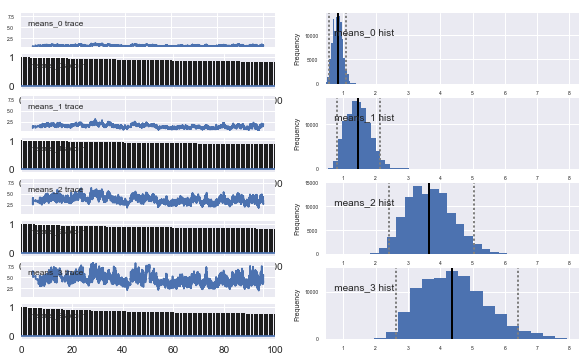

In [98]:
pm.Matplot.plot(means)

In [103]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


s = model.trace('states').gettrace()[:]

# data[data["WithStat"]=="stationary"]=0
# data[data["WithStat"]=="walk"]=1
# data[data["WithStat"]=="tube"]=2

data[data["WithStat"]=="stationary"]=0
data[data["WithStat"]=="walk"]=1
data[data["WithStat"]=="bus"]=2
# # data[data["WithStat"]=="train"]=3
data[data["WithStat"]=="tube"]=3

j = confusion_matrix(np.median(s,axis=0), (data[["WithStat"]].values.flatten()).astype(int))
print j
print "accuracy: ", float(np.trace(j))/j.sum()


[[304  43   4   0]
 [  3  40   0   0]
 [  1  13 164   0]
 [  1   1   0  11]]
accuracy:  0.887179487179


### END: For AllGPS4

### BEGIN: For AllGPS2

In [ ]:
import pandas as pd
import math
import geopandas as gpd
import numpy as np

dist = []
timeDiff = []
WithStat = []

df = gpd.read_file("F:\\AdelsCode\\Data\\AllGPS2WithCovariates.shp")
# df = df.sample(frac=0.6, replace=True)


df["nearTube"] = df["rail"]
df["nearBus"] = df["bus"]
df["div"] = df["SpeedMS"]

df["time"] = pd.to_datetime(df["fixTime"], format="%d/%m/%Y %H:%M")
df = df[(df['time'] > '13/05/2010') & (df['time'] < '20/05/2010')]
df = df.sort("time")
# df = df.iloc[0:100]
df = df.reset_index()

def distance(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return (c * r) * 1000

for i in range(0, df.shape[0]-1):
    lon2 = df.iloc[i]['latitude']
    lon1 = df.iloc[i+1]['latitude']
    lat2 = df.iloc[i]['longitude']
    lat1 = df.iloc[i+1]['longitude']
    dist.append(distance(lat1, lon1, lat2, lon2))
    timeDiff.append((df["time"][i+1]-df["time"][i]).total_seconds())
    WithStat.append(df.iloc[i+1]['WithStat'])
   
    #ids.append(df["id"][i])
   
df2 = pd.DataFrame(dist, columns = ['dist'])
i = 0
for x in timeDiff:
    if x<0:
        timeDiff[i]=0
    i = i+1
   
   
df2['time'] = timeDiff
df2['div'] = df2['dist']/df2['time']
df2['fixTime'] = df["fixTime"]
df2['nearBus'] = df["nearBus"]
df2['nearTube'] = df["nearTube"]
df2['IMDS10'] = df["IMDS10"]
df2['WithStat'] = WithStat
df2 = df2[df2['WithStat'] != 'cycle']

df2 = df2[np.isfinite(df['div'])]
df2 = df2.reset_index()

data = df2
data = data[["nearBus","nearTube","IMDS10","div", "WithStat"]]
# data.to_csv("F:\\AdelsCode\\Data\\test.csv")
data = data[data["div"] > 0]

data.reset_index(inplace=True)
X = data.iloc[:,[1,2,3]]
# X = data.iloc[:,[9,10,11]]
X = X.as_matrix()

print data.WithStat.unique(), len(data)


from random import sample
import pymc as pm
import pandas as pd
import numpy as np
import math



n = 4

N_chain = len(data)

a = []                                                         ### initial values
for i in data['WithStat']:
    if i == "stationary":
        a.append(0)
    elif i == "walk":
        a.append(1)
    elif i == "car":   
        a.append(2)
    elif i == "tube":
        a.append(3)
       
       
#### mutate initial values
def get_sample():
    s = sample(range(4),1)
    return s

def get_random_locations(a):
    s = sample(range(len(a)),1)
    return s

for i in range(0,50):
    a[get_random_locations(a)[0]] = get_sample()[0]
   
   
run = False

class HitAndRun(pm.Gibbs):
    def __init__(self, stochastic, proposal_sd=None, verbose=None):
        pm.Metropolis.__init__(self, stochastic, proposal_sd=proposal_sd,
                            verbose=verbose, tally=False)
        self.proposal_tau = self.proposal_sd**-2.
 
    def step(self):
        x0 = pm.copy(self.stochastic.value)
        dx = pm.rnormal(np.zeros(len(x0)), self.proposal_tau)
 
        logp = [self.logp_plus_loglike]
        x_prime = [x0]
 
        for direction in [-1, 1]:
            for i in xrange(25):
                delta = direction*np.exp(.1*i)*dx
                try:
                    self.stochastic.value = x0 + delta
                    logp.append(self.logp_plus_loglike)
                    x_prime.append(x0 + delta)
                except pm.ZeroProbability:
                    self.stochastic.value = x0
 
        i = pm.rcategorical(np.exp(np.array(logp) - pm.flib.logsum(logp)))
        self.stochastic.value = x_prime[i]
 
        if i == 0:
            self.rejected += 1
        else:
            self.accepted += 1
           
while run == False:
    try:
        b1 = pm.Normal('b1', mu=0., tau=30.)
        b2 = pm.Normal('b2', mu=0., tau=30.)
        b3 = pm.Normal('b3', mu=0., tau=30.)

        alpha = pm.Normal('alpha', mu=1.0, tau=30.)

      
      
        mu = pm.Container([pm.Uniform('mu1',0.,1.,value=np.random.rand(1)),pm.Uniform('mu2',0.,2.,value=np.random.rand(1)),
                           pm.Uniform('mu3',0.,10.,value=np.random.rand(1)),pm.Uniform('mu4',0.,30.,value=np.random.rand(1))])
       
#         sd = pm.Container([pm.Gamma('sd1',   0.8, 0.8),pm.Gamma('sd2', 0.7, 0.7),
#                            pm.Gamma('sd3', 0.6, 0.6),pm.Gamma('sd4', 0.5, 0.5)])
        sd = pm.Gamma('sd1',   0.01, 0.01, size=4)
        
        means = pm.Normal('means', mu,(1./sd**2),value=np.array([0.5, 1, 4, 6])) 

        precs = pm.Uniform('precs',  0., 500.,value=np.random.rand(n))
       
        theta =  pm.TruncatedNormal('theta', mu=1., tau=0.01, value=1., a=0.1, b=np.inf)
        theta1 =  pm.TruncatedNormal('theta1', mu=1., tau=0.01, value=1., a=0.1, b=np.inf)
        theta2 =  pm.TruncatedNormal('theta2', mu= 1., tau=0.01, value=1., a=0.1, b=np.inf)
        theta3 =  pm.TruncatedNormal('theta3', mu=1., tau=0.01, value=1., a=0.1, b=np.inf)
       
        def Ptrans_logp(value,theta,theta1,theta2,theta3):
           logp = 0.
           for i in range(value.shape[0]):
               logp = logp + pm.dirichlet_like(value[i], [theta,theta1,theta2,theta3])#*gamma
           return logp

        def Ptrans_random(theta=theta,theta1=theta1,theta2=theta2,theta3=theta3):
            return pm.rdirichlet(np.array([theta,theta1,theta2,theta3]), size=4)

        Ptrans = pm.Stochastic(logp=Ptrans_logp,
                                doc='Transition matrix',
                                name='Ptrans',
                                parents={'theta':theta,'theta1':theta1,'theta2':theta2,'theta3':theta3},
                                random=Ptrans_random)    
        def unconditionalProbability(Ptrans):
            m = Ptrans.shape[0]
            P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))
            I = np.eye(4)
            U = np.ones((4, 4))
            u = np.ones(4)          
            return np.linalg.solve((I - P + U).T, u)


       
        #Hidden states stochastic for the modes
        def states_logp(value, Ptrans=Ptrans):
            if sum(value > 3): # get rid of states greater than 2
                return -np.inf
            P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))
            Pinit = unconditionalProbability(Ptrans)
            logp = pm.categorical_like(value[0], Pinit)
            for i in range(2, len(value)):
                logp = logp + pm.categorical_like(value[i], P[value[i-1]])
#                 logp = logp + pm.categorical_like(value[i], P[value[i-2]])
                try:
                    if value[i] > 1:
                        if data['nearBus'][i] == 1 and data['nearTube'][i] == 0:
                            x = P[value[i-1]] * np.array([1,1,100,1])
                            x = x/sum(x)
                            logp = logp + pm.categorical_like(value[i], x)
                            logp = logp + pm.categorical_like(value[i], P[value[i-1]])
                            #logp = logp + pm.categorical_like(value[i], P[value[i-2]])

                        elif data['nearTube'][i] == 0 and data['nearBus'][i] == 0:
                            x = P[value[i-1]] * np.array([1,1,100,1])
                            x = x/sum(x)
                            logp = logp + pm.categorical_like(value[i], x)
                            logp = logp + pm.categorical_like(value[i], P[value[i-1]])
                            #ogp = logp + pm.categorical_like(value[i], P[value[i-2]])
#                         elif data['nearBus'][i] == 1 and data['railLines'][i] == 1:
#                             x = P[value[i-1]] * np.array([1,1,1,5])
#                             x = x/sum(x)
#                             logp = logp + pm.categorical_like(value[i], x)
#                             logp = logp + pm.categorical_like(value[i], P[value[i-1]])
#                         else:
                            logp = logp + pm.categorical_like(value[i], P[value[i-1]])
                    else:
                        logp = logp + pm.categorical_like(value[i], P[value[i-1]])

                except:
                    pass#pdb.set_trace()
            return logp

        def states_random(Ptrans=Ptrans, N_chain=N_chain):
           P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))
           Pinit = unconditionalProbability(Ptrans)
           states = np.empty(N_chain, dtype=np.uint8)
           states[0] = pm.rcategorical(Pinit)
           for i in range(1, N_chain):
               states[i] = pm.rcategorical(P[states[i-1]])
           return states



        states = pm.Stochastic(logp=states_logp,
                                doc='Hidden states',
                                name='states',
                                parents={'Ptrans': Ptrans},
                                random=states_random,
                                value = a,
                                dtype=np.uint8)
       

        @pm.deterministic
        def ordered(states=states, means=means):
            if means[0]< 0:
                return -np.inf
            else:
                if means[1]-means[0] < 0:
                    return -np.inf
                elif means[2]-means[1] < 0:
                    return -np.inf
                elif means[3]-means[2] < 0:
                    return -np.inf
                else:
                    return means[states]
        @pm.deterministic
        def eta(alpha=alpha,b1=b1, b2=b2,b3=b3):
            return alpha + b1 * X[:,0] + b2 * X[:,1] + b3 * X[:,2]
       
        @pm.stochastic(observed=True)
        def moving(eta=eta, ordered=ordered,precs=precs,states=states,value=data['div'].values):
            temp = eta*ordered
            return pm.normal_like(value,temp,(1./precs[states]**2))
       
       # moving = pm.Normal('moving', reg, 1./precs[states]**2, value=data['div'].values, observed = True) #1./precs[states]**2

        model = pm.MCMC([alpha,theta,theta1,theta2,theta3,eta, mu,sd, b1,b2,b3,
                         states,Ptrans, moving, means, precs, ordered], db='sqlite', dbname='F:\\AdelsCode\\Data\\simulation data\\AllGPS2WithCovariates.sqlite')#, db='sqlite', dbname='F://sims//3798086780243_260216.sqlite'
        #model.use_step_method(HitAndRun,means)
        model.use_step_method(pm.AdaptiveMetropolis,b1)
        model.use_step_method(pm.AdaptiveMetropolis,b2)
        model.use_step_method(pm.AdaptiveMetropolis,b3)

        #pm.MAP(model).fit()
        #model.use_step_method(SampleFromNormal,moving)
        model.use_step_method(pm.DiscreteMetropolis,states,positive=False, verbose=1)
            
#         graph = pm.graph.graph(model)
#         graph.write_png("graph2.png")
       
        model.sample(100000,tune_throughout = True)
        run = True
        model.db.close()
    except Exception,e:
        if 'means' in str(e):
            pass
        else:
            model.db.close()
            print str(e)
#             print ordered.value, means[0].value, means[1].value,means[2].value,means[3].value
#             pdb.set_trace()
#             traceback.print_exc()
        run = False

### END: For AllGPS2